In [731]:
import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from pathlib import Path
from joblib import dump


In [732]:
ham = Path("data/HAM10000_metadata.csv")

artifacts = Path("artifacts")
os.makedirs(artifacts, exist_ok=True)

ds = pd.read_csv(ham)
ds_orgin = ds
print("Dimension:", ds.shape)
ds.head()

epocas = 50

Dimension: (10015, 7)


In [733]:
cols = ['image_id', 'dx', 'age', 'sex', 'localization']
ds = ds[cols].copy()


for c in ['dx', 'sex', 'localization']:
    ds[c] = ds[c].astype(str).str.lower().str.strip()

ds['age'] = pd.to_numeric(ds['age'], errors='coerce')
ds['age'] = ds['age'].fillna(ds['age'].median())
ds['sex'] = ds['sex'].fillna('unknown')
ds['localization'] = ds['localization'].fillna('unknown')

print("Null en  columnas:{}".format(ds.isnull().sum().to_dict()))
ds.head()


Null en  columnas:{'image_id': 0, 'dx': 0, 'age': 0, 'sex': 0, 'localization': 0}


,image_id,dx,age,sex,localization
0,ISIC_0027419,bkl,80.0,male,scalp
1,ISIC_0025030,bkl,80.0,male,scalp
2,ISIC_0026769,bkl,80.0,male,scalp
3,ISIC_0025661,bkl,80.0,male,scalp
4,ISIC_0031633,bkl,75.0,male,ear


In [734]:
label_order = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
label_to_id = {name: idx for idx, name in enumerate(label_order)}
ds["label"] = ds["dx"].map(label_to_id)

X = ds[['sex', 'age', 'localization']]
y = ds['label']
ids = ds['image_id']
ds.head()


,image_id,dx,age,sex,localization,label
0,ISIC_0027419,bkl,80.0,male,scalp,2
1,ISIC_0025030,bkl,80.0,male,scalp,2
2,ISIC_0026769,bkl,80.0,male,scalp,2
3,ISIC_0025661,bkl,80.0,male,scalp,2
4,ISIC_0031633,bkl,75.0,male,ear,2


In [735]:
ds.shape

(10015, 6)

In [773]:
sex_map = {'male': 0, 'female': 1, 'unknown': 2}
ds['sex'] = ds['sex'].map(sex_map)

ds['localization'] = ds['localization'].astype('category').cat.codes

X = ds[['sex', 'age', 'localization']]
y = ds['label']

X_train_val, X_test, y_train_val, y_test, ids_train_val, ids_test = train_test_split(X, y, ds['image_id'], test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split( X_train_val, y_train_val, ids_train_val, test_size=0.25, stratify=y_train_val, random_state=42 )

scaler = StandardScaler()
scaler.fit(X_train)

X_train_proc = scaler.transform(X_train)
X_val_proc = scaler.transform(X_val)
X_test_proc = scaler.transform(X_test)

print("Shape transformado (train):", X_train_proc.shape)


print(f"entrenamiento: {len(X_train)}")
print(f"validación: {len(X_val)}")
print(f"test: {len(X_test)}")

Shape transformado (train): (6009, 3)
entrenamiento: 6009
validación: 2003
test: 2003


c:\Users\hades\anaconda3\envs\deepcpu\lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\hades\anaconda3\envs\deepcpu\lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\hades\anaconda3\envs\deepcpu\lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [774]:
os.makedirs(artifacts, exist_ok=True)

dump(scaler, os.path.join(artifacts, "scaler_tabular.joblib"))

pd.Series(ids_train).to_csv(os.path.join(artifacts, "train_ids.csv"), index=False)
pd.Series(ids_val).to_csv(os.path.join(artifacts, "val_ids.csv"), index=False)
pd.Series(ids_test).to_csv(os.path.join(artifacts, "test_ids.csv"), index=False)

with open(os.path.join(artifacts, "label_map.json"), "w") as f:
    json.dump(label_to_id, f, indent=2)

In [739]:
nclases = 7
dimnenciones = X_train_proc.shape[1]
print("Número de clases:", dimnenciones)

modelo_tabular =  keras.Sequential([
    layers.Input(shape=(dimnenciones,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(nclases, activation='softmax')
])
modelo_tabular.summary()

Número de clases: 3


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_157 (Dense)               │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,223 (36.03 KB)

 Trainable params: 9,223 (36.03 KB)

 Non-trainable params: 0 (0.00 B)

In [740]:
modelo_tabular.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [741]:
historial = modelo_tabular.fit(X_train_proc, y_train, validation_data=(X_val_proc, y_val), epochs=epocas, batch_size=32)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6610 - loss: 1.1198 - val_accuracy: 0.6815 - val_loss: 0.9920
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6733 - loss: 1.0171 - val_accuracy: 0.6860 - val_loss: 0.9811
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 1.0064 - val_accuracy: 0.6860 - val_loss: 0.9737
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6805 - loss: 0.9990 - val_accuracy: 0.6880 - val_loss: 0.9672
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.9888 - val_accuracy: 0.6875 - val_loss: 0.9606
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6816 - loss: 0.9893 - val_accuracy: 0.6855 - val_loss: 0.9569
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6835 - loss: 0.9818 - val_accuracy: 0.6890 - val_loss: 0.9507
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6810 - loss: 0.9762 - val_accuracy: 0.

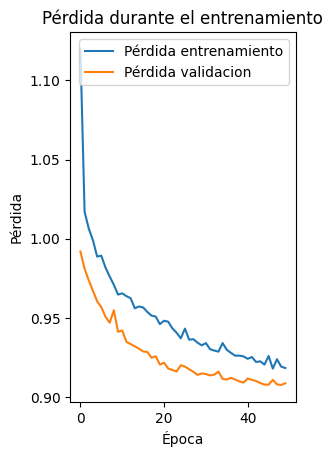

In [742]:
plt.Figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(historial.history['loss'], label='Pérdida entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida validacion')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

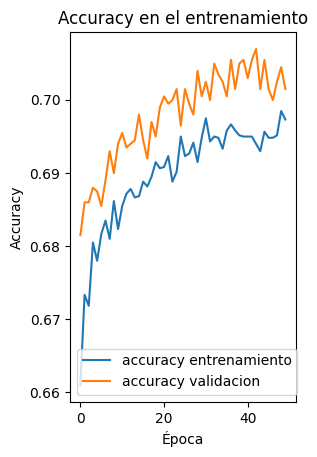

In [743]:
plt.subplot(1, 2, 2)
plt.plot(historial.history['accuracy'], label='accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='accuracy validacion')
plt.title('Accuracy en el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [744]:
test_loss, test_accuracy = modelo_tabular.evaluate(X_test_proc, y_test)
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6985 - loss: 0.9362  
Pérdida en test: 0.9362
Accuracy en test: 0.6985


In [745]:
imgs_paht = Path("data/Ham10000_images")
artifacts = Path("artifacts")

train = pd.read_csv(artifacts / "train_ids.csv")['image_id'].tolist()
val = pd.read_csv(artifacts / "val_ids.csv")['image_id'].tolist()
test = pd.read_csv(artifacts / "test_ids.csv")['image_id'].tolist()
print(f"Número de imágenes en train: {len(train)}")
print(f"Número de imágenes en val: {len(val)}")
print(f"Número de imágenes en test: {len(test)}")

Número de imágenes en train: 6009
Número de imágenes en val: 2003
Número de imágenes en test: 2003


In [746]:
tam_img = (32, 32)
def cargayproceso(imgid):
    img_path = imgs_paht / f"{imgid}.jpg"
    img = image.load_img(img_path, target_size=tam_img)
    img_array = image.img_to_array(img)
    # img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [747]:
def creads (list_ids):
    images = []
    for img_id in list_ids:
        img_array = cargayproceso(img_id)
        images.append(img_array)
    images = np.array(images)
    return images

X_train_img = creads(train)
X_val_img = creads(val)
X_test_img = creads(test)
print("Shape train imágenes:", X_train_img.shape)
print("Shape val imágenes:", X_val_img.shape)
print("Shape test imágenes:", X_test_img.shape)

Shape train imágenes: (6009, 32, 32, 3)
Shape val imágenes: (2003, 32, 32, 3)
Shape test imágenes: (2003, 32, 32, 3)


In [748]:
ds_orgin['label'] = ds_orgin['dx'].map(label_to_id)

y_train_img = ds_orgin[ds_orgin['image_id'].isin(train)]['label'].values
y_val_img = ds_orgin[ds_orgin['image_id'].isin(val)]['label'].values
y_test_img = ds_orgin[ds_orgin['image_id'].isin(test)]['label'].values
print("Shape train imágenes:", y_train_img.shape)
print("Shape val imágenes:", y_val_img.shape)
print("Shape test imágenes:", y_test_img.shape)

Shape train imágenes: (6009,)
Shape val imágenes: (2003,)
Shape test imágenes: (2003,)


In [ ]:
inputs_img = keras.Input(shape=(32, 32, 3), name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs_img)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
features = layers.Dense(128, activation='relu', name="visual_features")(x)
x = layers.Dropout(0.2)(features)

outputs = layers.Dense(nclases, activation='softmax')(x)
modelo_img = keras.Model(inputs=inputs_img, outputs=outputs, name="modelo_visual")
modelo_img.summary()
    

Model: "modelo_visual"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ visual_features (Dense)         │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,335 (1.20 MB)

 Trainable params: 315,335 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [750]:
modelo_img.compile( optimizer= keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [751]:
historial = modelo_img.fit(X_train_img, y_train_img, validation_data=(X_val_img, y_val_img), epochs=epocas, batch_size=32)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6665 - loss: 1.1810 - val_accuracy: 0.6695 - val_loss: 1.1401
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1525 - val_accuracy: 0.6695 - val_loss: 1.1391
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1566 - val_accuracy: 0.6695 - val_loss: 1.1436
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1478 - val_accuracy: 0.6695 - val_loss: 1.1418
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1439 - val_accuracy: 0.6695 - val_loss: 1.1477
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1481 - val_accuracy: 0.6695 - val_loss: 1.1328
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1377 - val_accuracy: 0.6695 - val_loss: 1.1428
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6695 - loss: 1.1400 - val_accuracy: 0.

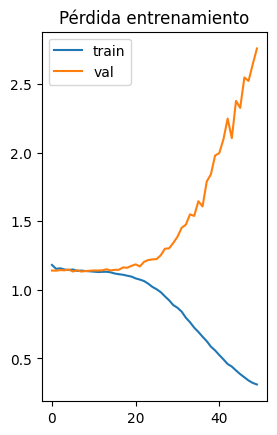

In [752]:
plt.subplot(1,2,1)
plt.plot(historial.history['loss'], label='Pérdida entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida validacion')
plt.title('Pérdida entrenamiento')
plt.legend(["train", "val"])
plt.show()

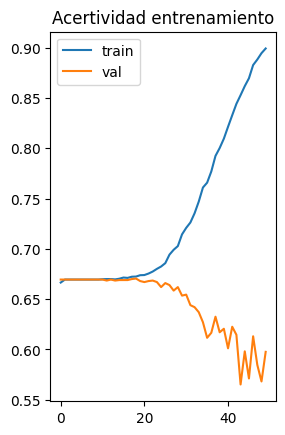

In [753]:
plt.subplot(1,2,2)
plt.plot(historial.history['accuracy'], label='Acertividad entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Acertividad validacion')
plt.title('Acertividad entrenamiento')
plt.legend(["train", "val"])
plt.show()

In [754]:
test_loss, test_acc = modelo_img.evaluate(X_test_img, y_test_img)
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5801 - loss: 2.8913 
Pérdida en test: 2.8913
Accuracy en test: 0.6985


In [755]:
dim = X_train_proc.shape[1]
print("Dimensiones de entrada para el modelo tabular:", dim)
inputs_tab = keras.Input(shape=(dim,), name="input_tabular")

x = layers.Dense(128, activation='relu')(inputs_tab)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(nclases, activation='softmax')(x)

modelo_tabular = keras.Model(inputs=inputs_tab, outputs=outputs, name="modelo_tabular")
#modelo_tabular.summary()

Dimensiones de entrada para el modelo tabular: 3


In [756]:
extractor_tabular = keras.Model(modelo_tabular.input,modelo_tabular.layers[-2].output)

X_train_tab = extractor_tabular.predict(X_train_proc)
X_val_tab   = extractor_tabular.predict(X_val_proc)
X_test_tab  = extractor_tabular.predict(X_test_proc)
print("Shape train tabular features:", X_train_tab.shape)
print("Shape val tabular features:", X_val_tab.shape)
print("Shape test tabular features:", X_test_tab.shape)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
Shape train tabular features: (6009, 64)
Shape val tabular features: (2003, 64)
Shape test tabular features: (2003, 64)


In [757]:
extractor_visual = keras.Model(modelo_img.input, modelo_img.layers[-2].output)
X_train_vis = extractor_visual.predict(X_train_img)
X_val_vis   = extractor_visual.predict(X_val_img)
X_test_vis  = extractor_visual.predict(X_test_img)

print("Shape train tabular features:", X_train_vis.shape)
print("Shape val tabular features:", X_val_vis.shape)
print("Shape test tabular features:", X_test_vis.shape)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Shape train tabular features: (6009, 128)
Shape val tabular features: (2003, 128)
Shape test tabular features: (2003, 128)


In [758]:
invis = layers.Input(shape=(X_train_vis.shape[1],))
v = layers.Dense(64, activation='relu')(invis)
modelo_img_vis = keras.Model(invis, v)

X_train_vis_red = modelo_img_vis.predict(X_train_vis)
X_val_vis_red   = modelo_img_vis.predict(X_val_vis)
X_test_vis_red  = modelo_img_vis.predict(X_test_vis)
print("Shape train tabular features:", X_train_vis_red.shape)
print("Shape val tabular features:", X_val_vis_red.shape)
print("Shape test tabular features:", X_test_vis_red.shape)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Shape train tabular features: (6009, 64)
Shape val tabular features: (2003, 64)
Shape test tabular features: (2003, 64)


In [759]:
input_tab = layers.Input(shape=(X_train_tab.shape[1],))
input_vis = layers.Input(shape=(X_train_vis_red.shape[1],))

fusion = layers.Concatenate()([input_tab, input_vis])  # → (N, 128)

x = layers.Dense(128, activation='relu')(fusion)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(7, activation='softmax')(x)

fusion_model = keras.Model(inputs=[input_tab, input_vis], outputs=out)
fusion_model.summary()


Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_56      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ input_layer_55[0… │
│ (Concatenate)       │                   │            │ input_layer_56[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 128)       │     16,512 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_100         │ (None, 128)       │          0 │ dense_165[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_166 (Dense)   │ (None, 64)        │      8,256 │ dropout_100[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_167 (Dense)   │ (None, 7)         │        455 │ dense_166[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,223 (98.53 KB)

 Trainable params: 25,223 (98.53 KB)

 Non-trainable params: 0 (0.00 B)

In [760]:
fusion_model.compile( optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_fusion = fusion_model.fit([X_train_tab, X_train_vis_red], y_train_img, validation_data=([X_val_tab, X_val_vis_red], y_val_img), epochs=epocas, batch_size=32)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7033 - loss: 0.9319 - val_accuracy: 0.6036 - val_loss: 1.7694
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8036 - loss: 0.5737 - val_accuracy: 0.5582 - val_loss: 2.1204
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4785 - val_accuracy: 0.5597 - val_loss: 2.2989
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.4314 - val_accuracy: 0.5756 - val_loss: 2.4989
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.3936 - val_accuracy: 0.5776 - val_loss: 2.6204
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8697 - loss: 0.3745 - val_accuracy: 0.5452 - val_loss: 2.5871
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8772 - loss: 0.3569 - val_accuracy: 0.5662 - val_loss: 2.7334
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8798 - loss: 0.3471 - val_accuracy: 0.

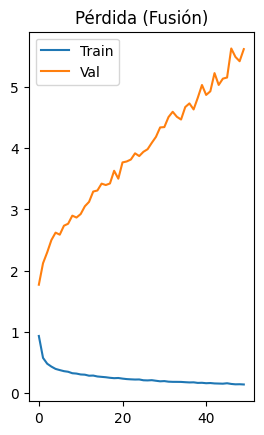

In [761]:
plt.subplot(1,2,1)
plt.plot(history_fusion.history['loss'])
plt.plot(history_fusion.history['val_loss'])
plt.title("Pérdida (Fusión)")
plt.legend(["Train", "Val"])
plt.show()

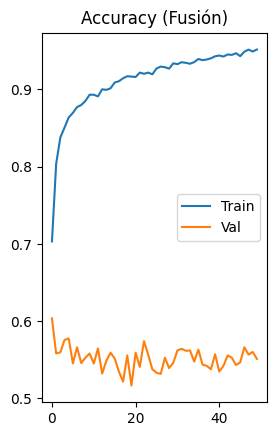

In [762]:
plt.subplot(1,2,2)
plt.plot(history_fusion.history['accuracy'])
plt.plot(history_fusion.history['val_accuracy'])
plt.title("Accuracy (Fusión)")
plt.legend(["Train", "Val"])
plt.show()

In [763]:
test_loss, test_acc = fusion_model.evaluate([X_test_tab, X_test_vis_red], y_test_img)

print(f"Accuracy final de FUSIÓN: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5167 - loss: 5.7787    
Accuracy final de FUSIÓN: 0.5167


En esta práctica se evaluaron algunos mecanismos para clasificación de lesiones en la piel por Cancer. Modelo basado en variables clínicas, un modelo visual, y un modelo multimodal que combina ambas fuentes de información. Los resultados muestran diferencias en la capacidad predictiva de cada una.

El primer modelo se baso en el archivo csv proporcionado por el profesor y con la información que se recabo se logró llegar a casi un .69 de asertividad.

El modelo visual que se realizo en base a las imágenes descargades de (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T), esto dado a que no logre realizar la correlación de los CSV proporcionados por el profesor y con las imágenes descargas se realizo con 10,015 imagens se logro llegar al .61 de asertividad

Al realizar la unión de ambos modelos tuve una baja muy fuerte al solo lograr un .54 de asertividad 

Nota. quizas mi falta de experiencia no me logro generar una mejor acertivdiad con la información pero siguere intentanto con esta practica.
